In [1]:
# Import packages here
import numpy as np
import xarray as xr
import pandas as pd
import netCDF4 as nc

import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy
from cartopy import config
import cartopy.crs as ccrs

import climlab
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import warnings

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
warnings.filterwarnings('ignore')
%matplotlib inline

/data/keeling/a/tjhanke2/miniconda3/lib/python3.8/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex
/tmp/ipykernel_12981/2503136231.py:18: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
# Global functions
# Get anomalies (y/n for deseasonalizing)
def get_anomaly(x,detrend):
    clim = x.groupby('time.month').mean(dim='time')
    anom = x.groupby('time.month') - clim
    if detrend == 1:
        poly = anom.polyfit(dim='time', deg=1)
        fit = xr.polyval(anom['time'], poly.polyfit_coefficients)
        return anom - fit
    else:
        return anom

# Get global-mean values, weighted by latitude
def global_mean(x):
    weights = np.cos(np.deg2rad(x.latitude))
    return x.weighted(weights).mean(dim=('latitude','longitude'))

### tosbcs 

In [5]:
## Load data
path = '/data/keeling/a/rytam2/a/ppe_input/ctl_bc/preprocessed/'
tosbcs = xr.open_dataset(path+'tosbcs_input4MIPs_SSTsAndSeaIce_CMIP_PCMDI-AMIP-1-1-9_gn_187001-202212.nc').tosbcs.sel(time=slice('2000-03','2022-02'))

## Get SST anomalies and nino3.4 index
SST_anom = get_anomaly(tosbcs,1)
nino34 = global_mean(get_anomaly(tosbcs.sel(lat=slice(-5,5),lon=slice(190,240)).rename({'lat':'latitude','lon':'longitude'}),1))

### tos 

In [37]:
## Load data
path = '/data/keeling/a/rytam2/a/ppe_input/ctl_bc/preprocessed/'
tos = xr.open_dataset(path+'tos_input4MIPs_SSTsAndSeaIce_CMIP_PCMDI-AMIP-1-1-9_gn_187001-202212.nc').tos.sel(time=slice('2000-03','2022-02'))

## Get SST anomalies and nino3.4 index
SST_anom = get_anomaly(tos,1)
nino34 = global_mean(get_anomaly(tos.sel(lat=slice(-5,5),lon=slice(190,240)).rename({'lat':'latitude','lon':'longitude'}),1))

# Lagged Composites

In [6]:
## Define El Nino and La Nina years using Dec values > 1STD of nino3.4 as threshold
en = []
ln = []
for i in range(0,len(nino34)):
    if nino34[i].time.dt.month == 12 and nino34[i] >= nino34.std() and nino34[i].time.dt.year not in en:
        en.append(int(nino34[i].time.dt.year))
    if nino34[i].time.dt.month == 12 and nino34[i] <= -nino34.std() and nino34[i].time.dt.year not in ln:
        ln.append(int(nino34[i].time.dt.year))
        
## Define backward and forward years for lagged composites
el_nino_yrs = np.concatenate([np.array(en),np.array(en)+1]).reshape(2,len(en))
la_nina_yrs = np.concatenate([np.array(ln),np.array(ln)+1]).reshape(2,len(ln))

In [7]:
## For each month, composite radiation to get radiation maps as a function of lag
def get_mon_comp(x):
    en_start = x.sel(time=x.time.dt.year.isin(el_nino_yrs[0])) # neg. lags
    en_end = x.sel(time=x.time.dt.year.isin(el_nino_yrs[1])) # pos. lags
    ln_start = x.sel(time=x.time.dt.year.isin(la_nina_yrs[0]))
    ln_end = x.sel(time=x.time.dt.year.isin(la_nina_yrs[1]))
    
    # average across neg. lags
    start_grp = (en_start.groupby('time.month').mean(dim='time') - ln_start.groupby('time.month').mean(dim='time')) / 2
    start_grp['month'] = np.arange(-11,1,1)
    start_grp = start_grp.rename({'month':'lag'})
    
    # average across pos. lags
    end_grp = (en_end.groupby('time.month').mean(dim='time') - ln_end.groupby('time.month').mean(dim='time')) / 2
    end_grp['month'] = np.arange(1,13,1)
    end_grp = end_grp.rename({'month':'lag'})
    
    # combine lags into one da
    mon_comp_xr = xr.concat([start_grp,end_grp], dim='lag')
    
    return mon_comp_xr

SST_composites = get_mon_comp(SST_anom)

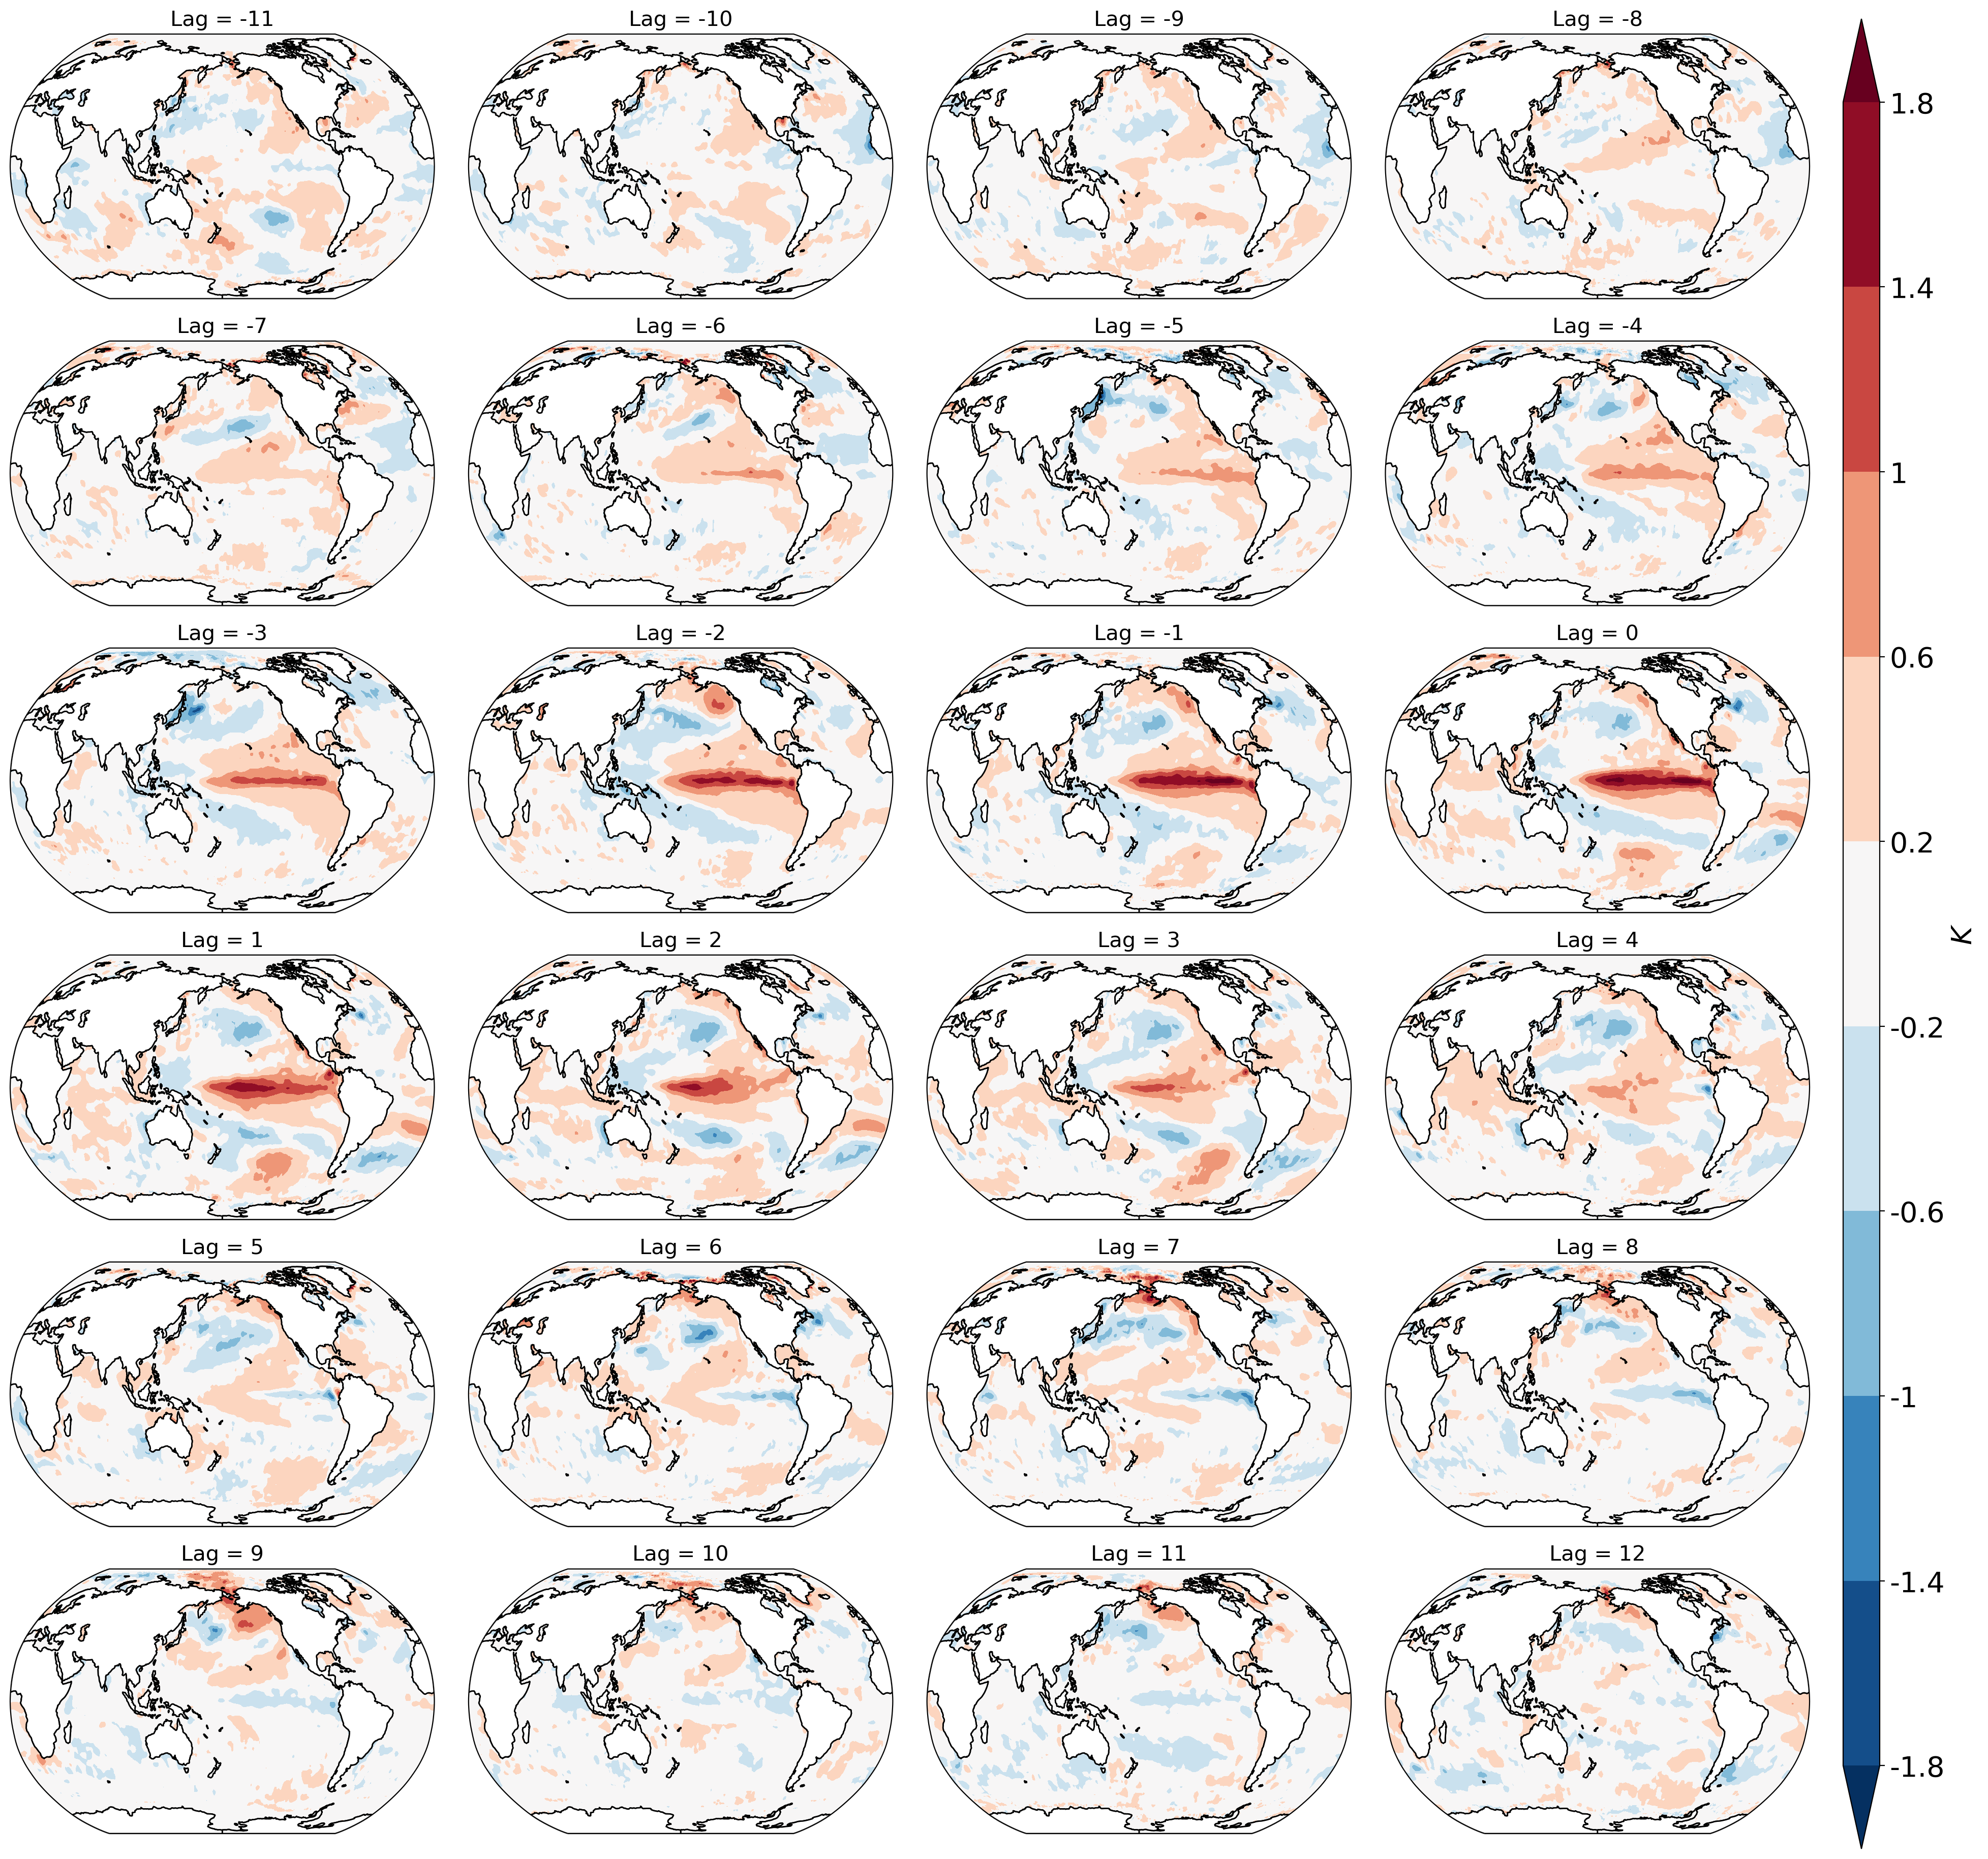

In [8]:
fig, ax = plt.subplots(6,4,figsize=(18,18),subplot_kw={'projection': ccrs.Robinson(central_longitude=180)},dpi=200)
fig.tight_layout(w_pad=10,h_pad=3)

lags = np.arange(-11,13).reshape([6,4])
levels = np.linspace(-1.8,1.8,10)

for i in range(0,6):
    for j in range(0,4):
        cbar_data = ax[i,j].contourf(SST_composites.lon,SST_composites.lat,SST_composites.sel(lag=lags[i,j]),
                               add_colorbar=False,levels=levels,cmap=plt.get_cmap('RdBu_r'),transform=ccrs.PlateCarree(),extend='both')
        ax[i,j].set_ylabel('')
        ax[i,j].set_xlabel('')
        ax[i,j].set_title('Lag = '+str(lags[i,j]),size=15)
        
        ax[i,j].add_feature(cartopy.feature.LAND,zorder=100,facecolor='w',edgecolor='k')
        ax[i,j].coastlines()
        ax[i,j].set_aspect('auto')
        ax[i,j].set_global()
        if i == 0 and j == 0:
            cbar_ax = fig.add_axes([1.01, 0, 0.02, 1])
            cbar = fig.colorbar(cbar_data, cax=cbar_ax, orientation='vertical', extend='both', format='%g', ticks=levels)
            cbar.ax.tick_params(labelsize=20)
            cbar.set_label(label='$K$', size=20)
            
# fig.savefig('composite_maps_ENSO_SST.png',bbox_inches='tight')

In [40]:
## Save composites
SST_composites.to_netcdf('tos_CMIP_PCMDI-AMIP-1-1-9_composite_maps_ENSO_SST_2000-03_2022-02.nc')

# Lagged Regression

In [9]:
## Define regression function
def OLS(x,y):
    x_const = sm.add_constant(x)
    reg = sm.OLS(y,x_const).fit()

    coefs = reg.params[1]
    return coefs
    
## Define lagged regression function
def lagged_regress(x,y,lag): 
    x_lag = x.shift(time=lag).transpose('time',...) # shift by lag on time-axis
    
    # check if y is 3D [lat,lon,t] or 1D [t]
    if y.ndim == 3:
        y_dim_list = y.transpose('time',...).dims
        y_stack = y.stack(allpoints=y_dim_list[1:len(y_dim_list)]).transpose('time',...)
    else:
        y_stack = y
    a_lag, b_stack = xr.align(x_lag.dropna(dim='time'),
                              y_stack.where(np.isinf(y_stack)==False, np.nan).where(np.isnan(y_stack)==False, drop=True))
    
    # determine if reshaping x is necessary; make X, y into numpy arrays (helps sm.OLS run quicker)
    if x_lag.ndim == 1:
        a_lag_np = a_lag.values.reshape(-1,1)
    else:
        a_lag_np = a_lag.values
    b_stack_np = b_stack.values
    
    # apply vectorized regression function at all [lat,lon] and format into xarray
    coefs = xr.apply_ufunc(OLS,a_lag_np,b_stack_np)
    if y.ndim == 3:
        coefs_xr = xr.DataArray(data=coefs,
                                coords={'dim_0':range(0,len(b_stack.allpoints))}).rename({'dim_0':'allpoints'}).assign_coords({'allpoints':b_stack.allpoints}).unstack()
        coefs_xr = coefs_xr
    else:
        coefs_xr = xr.DataArray(data=coefs)
    
    return coefs_xr

## Define function to loop lagged regression function
def time2lag(x, y, lag_list):
    y_lag = []
    for i in lag_list:
        y_lag.append(lagged_regress(x,y,i))

    return xr.concat(y_lag,dim='lag').assign_coords({'lag':lag_list})

In [10]:
## Regress SST onto nino3.4 (scale by the STD DEV of Dec composites)
SST_lr = time2lag(nino34, SST_anom, np.arange(-11,13)) * get_mon_comp(nino34).sel(lag=0)

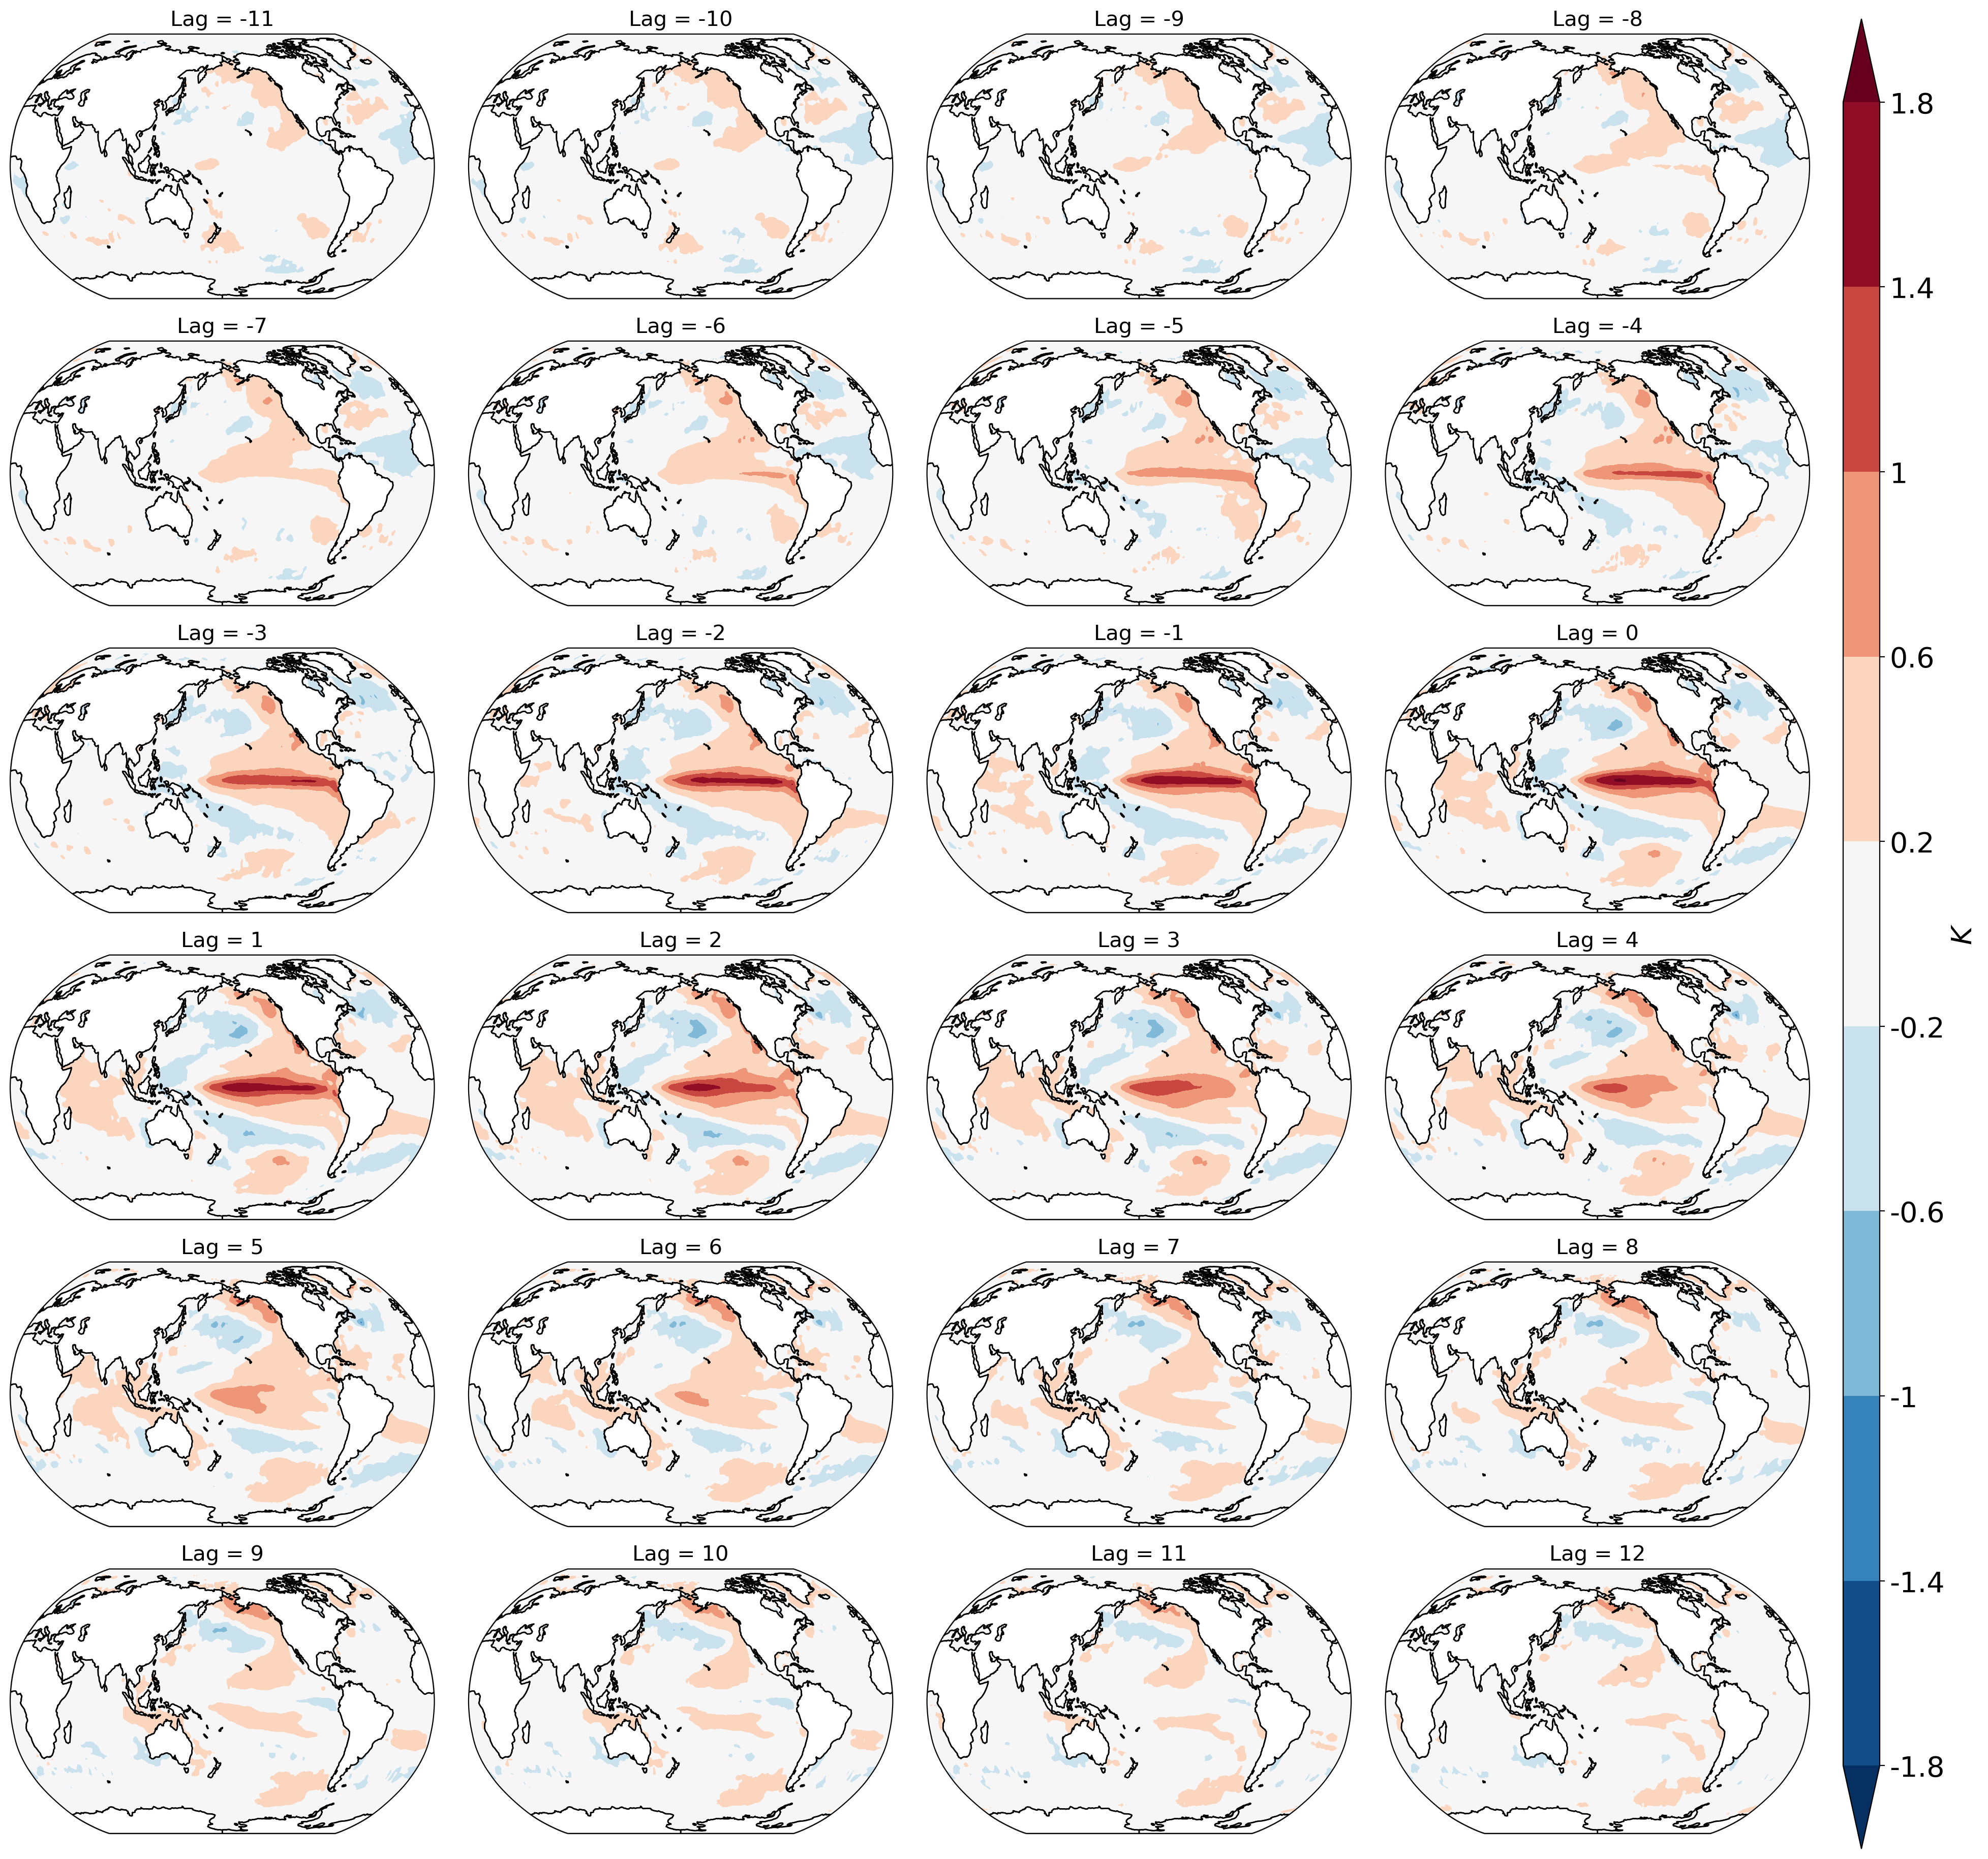

In [11]:
fig, ax = plt.subplots(6,4,figsize=(18,18),subplot_kw={'projection': ccrs.Robinson(central_longitude=180)},dpi=200)
fig.tight_layout(w_pad=10,h_pad=3)

lags = np.arange(-11,13).reshape([6,4])
levels = np.linspace(-1.8,1.8,10)

for i in range(0,6):
    for j in range(0,4):
        cbar_data = ax[i,j].contourf(SST_lr.lon,SST_lr.lat,SST_lr.sel(lag=lags[i,j]),
                               add_colorbar=False,levels=levels,cmap=plt.get_cmap('RdBu_r'),transform=ccrs.PlateCarree(),extend='both')
        ax[i,j].set_ylabel('')
        ax[i,j].set_xlabel('')
        ax[i,j].set_title('Lag = '+str(lags[i,j]),size=15)
        
        ax[i,j].add_feature(cartopy.feature.LAND,zorder=100,facecolor='w',edgecolor='k')
        ax[i,j].coastlines()
        ax[i,j].set_aspect('auto')
        ax[i,j].set_global()
        if i == 0 and j == 0:
            cbar_ax = fig.add_axes([1.01, 0, 0.02, 1])
            cbar = fig.colorbar(cbar_data, cax=cbar_ax, orientation='vertical', extend='both', format='%g', ticks=levels)
            cbar.ax.tick_params(labelsize=20)
            cbar.set_label(label='$K$', size=20)
            
# fig.savefig('lr_maps_ENSO_SST.png',bbox_inches='tight')

In [44]:
## Save lagged regression
SST_lr.to_netcdf('tos_CMIP_PCMDI-AMIP-1-1-9_lagged_regression_maps_ENSO_SST_2000-03_2022-02.nc')